In [1]:
import os, json, gzip, pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [2]:
###################################### LOAD DATA #############################################################
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz
# l.strip() to prevent the load of empty line
# get into pandas dataframe for better data handling
input_file = '../Data/reviews_Cell_Phones_and_Accessories_5.json.gz'
data = []
with gzip.open(input_file) as f:
    for l in f:
        data.append(json.loads(l.strip()))

df = pd.DataFrame.from_dict(data)
df = df[['reviewText', 'overall']]

print("Amount of reviews: ", len(data))

print(df.loc[0])

Amount of reviews:  194439
reviewText    They look good and stick good! I just don't li...
overall                                                       4
Name: 0, dtype: object


In [3]:
############################# DUPLICATE DETECTION & DELETION ##################################################
print('Before deleting duplicate entries: ', len(df))
df = df.drop_duplicates()
print('After deleting duplicate entries: ', len(df))
dup = df[df['reviewText'].isin(df['reviewText'][df['reviewText'].duplicated()])]
# print(len(dup))
# print(dup[5:50])
df = df.drop_duplicates(subset=['reviewText'])
print('After deleting duplicate review texts: ', len(df))

# Sample survey
# dup[(dup['reviewText'].str.contains("love") | dup['reviewText'].str.contains("Love") | dup['reviewText'].str.contains("LOVE"))]
# dup[(dup['reviewText'].str.contains("good") | dup['reviewText'].str.contains("Good"))]
# dup[(dup['reviewText'].str.contains("great") | dup['reviewText'].str.contains("Great"))]
# dup[(dup['reviewText'].str.contains("ok") | dup['reviewText'].str.contains("OK"))]
# dup[(dup['reviewText'].str.contains("nice") | dup['reviewText'].str.contains("Nice"))]
# dup[(dup['reviewText'].str.contains("perfect") | dup['reviewText'].str.contains("Perfect"))]

Before deleting duplicate entries:  194439
After deleting duplicate entries:  194226
After deleting duplicate review texts:  194186


In [4]:
################################## EMPTY REVIEWS DELETION ######################################################
print('Before deleting empty review texts: ', len(df))
df = df[df['reviewText'] != '']
print('After deleting empty review texts: ', len(df))
# df[df['reviewText'].str.contains("null")]

Before deleting empty review texts:  194186
After deleting empty review texts:  194185


The longest review text in our sample has 5424 words.
Longest review text:

91829    This phone seemed nothing short of a dream com...
Name: reviewText, dtype: object
The shortest review text in our sample has 1 words.
Review text with the shortest length of 1 word appearing 74 times.


count    194185.000000
mean         93.106373
std         136.911652
min           1.000000
25%          28.000000
50%          48.000000
75%         102.000000
max        5424.000000
Name: word_count, dtype: float64

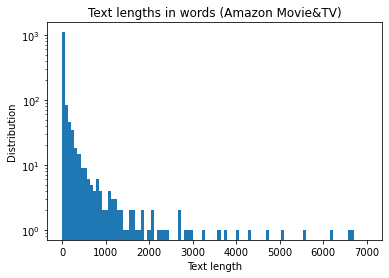

In [5]:
#################################### WORD COUNT ################################################################
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split(" ")))

longest_t = df[df['word_count'] == max(df['word_count'])]
print('The longest review text in our sample has {} words.'.format(max(df['word_count'])))
print('Longest review text:' + '\n')
print(longest_t.reviewText)

shortest_t = df[df['word_count'] == min(df['word_count'])]
print('The shortest review text in our sample has {} words.'.format(min(df['word_count'])))
print('Review text with the shortest length of {} word appearing {} times.'.format(min(df['word_count']), len(shortest_t)))

plt.rcParams['figure.facecolor'] = 'white'
plt.hist(df['word_count'].value_counts().sort_index(), range=(0,7000), bins=100, log=True)
plt.xlabel('Text length')
plt.ylabel('Distribution')
plt.title('Text lengths in words (Amazon Movie&TV)')

df['word_count'].describe()

5.0    108480
4.0     39950
3.0     21429
1.0     13267
2.0     11059
Name: overall, dtype: int64


(array([ 13267.,  11059.,  21429.,  39950., 108480.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <BarContainer object of 5 artists>)

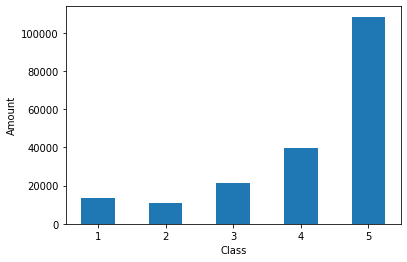

In [6]:
################################## RATING DISTRIBUTION ###########################################

print(df['overall'].value_counts())
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Class')
plt.ylabel('Amount')
plt.hist(df['overall'], bins=np.arange(0.5, 6), rwidth=0.5)

